## Patient Survival Prediction

<font color="blue">Problem Statement:</font>

<p>The aim or goal of the project is to predict survival of patients with heart failure based on clinical features. In this project different supervised machine learning classification algorithms will be used to predict the target death event of the patient. Feature selection and other hyperparameter tuning methods are used to build an accurately predicting model.</p>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, roc_auc_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFE, f_regression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.model_selection import cross_val_score
import seaborn as sns
import xgboost as xgb
import sqlite3 as sql
import numpy as np

In [2]:
clinical_data = pd.read_csv('heart_failure_clinical_records_dataset.csv')

In [3]:
clinical_data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
clinical_data.shape

(299, 13)

The dataset consists of 13 attributes:

* age: age of the patient (years)
* anaemia: decrease of red blood cells or hemoglobin (boolean)
* high blood pressure: if the patient has hypertension (boolean)
* creatinine phosphokinase (CPK): level of the CPK enzyme in the blood (mcg/L)
* diabetes: if the patient has diabetes (boolean)
* ejection fraction: percentage of blood leaving the heart at each contraction (percentage)
* platelets: platelets in the blood (kiloplatelets/mL)
* sex: woman or man (binary)
* serum creatinine: level of serum creatinine in the blood (mg/dL)
* serum sodium: level of serum sodium in the blood (mEq/L)
* smoking: if the patient smokes or not (boolean)
* time: follow-up period (days)
* death event (Target Variable): if the patient deceased during the follow-up period (boolean)

In [5]:
anaemia_deaths = clinical_data.groupby(['anaemia', 'DEATH_EVENT'])['DEATH_EVENT'].count().unstack()
anaemia_deaths

DEATH_EVENT,0,1
anaemia,,
0,120,50
1,83,46


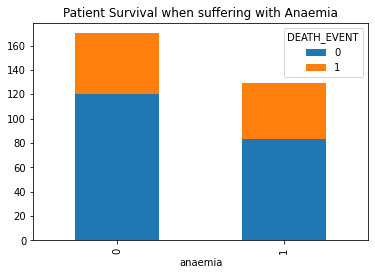

In [6]:
anaemia_deaths.plot(kind='bar', stacked=True)
plt.title('Patient Survival when suffering with Anaemia')
plt.show()

In [7]:
diabetes_deaths = clinical_data.groupby(['diabetes', 'DEATH_EVENT'])['DEATH_EVENT'].count().unstack()
diabetes_deaths

DEATH_EVENT,0,1
diabetes,,
0,118,56
1,85,40


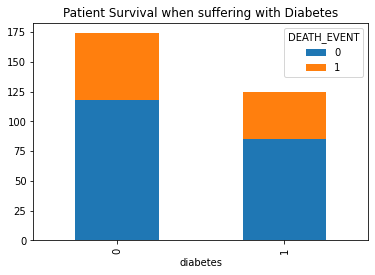

In [8]:
diabetes_deaths.plot(kind='bar', stacked=True)
plt.title('Patient Survival when suffering with Diabetes')
plt.show()

In [9]:
high_blood_pressure_deaths = clinical_data.groupby(['high_blood_pressure', 'DEATH_EVENT'])['DEATH_EVENT'].count().unstack()
high_blood_pressure_deaths

DEATH_EVENT,0,1
high_blood_pressure,,
0,137,57
1,66,39


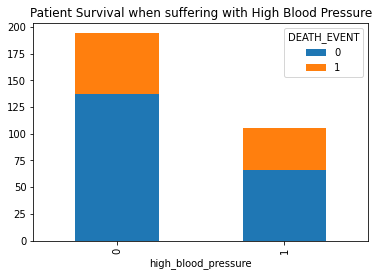

In [10]:
high_blood_pressure_deaths.plot(kind='bar', stacked=True)
plt.title('Patient Survival when suffering with High Blood Pressure')
plt.show()

In [11]:
sex_deaths = clinical_data.groupby(['sex', 'DEATH_EVENT'])['DEATH_EVENT'].count().unstack()
sex_deaths

DEATH_EVENT,0,1
sex,,
0,71,34
1,132,62


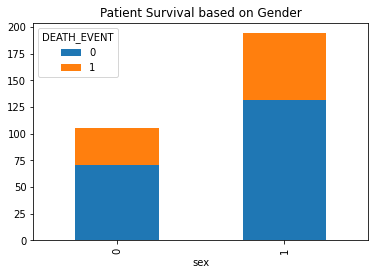

In [12]:
sex_deaths.plot(kind='bar', stacked=True)
plt.title('Patient Survival based on Gender')
plt.show()

In [13]:
#Extracting the independent (Input variables) and dependednt (target variable)
X = clinical_data.iloc[:,:-1]
y = clinical_data.iloc[:,-1:]

In [14]:
#Checking the shape of input variables
X.shape

(299, 12)

In [15]:
#Checking the shape of target variable
y.shape

(299, 1)

In [16]:
#Checking the statistics of input variables
X.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000


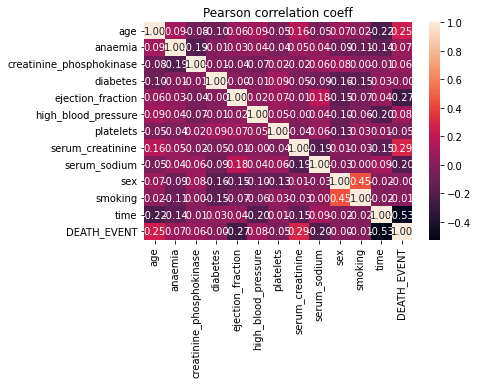

In [17]:
ax = plt.axes()
ax.set_title('Pearson correlation coeff')
sns.heatmap(clinical_data.corr(), annot=True, fmt=".2f",ax = ax)
plt.show()

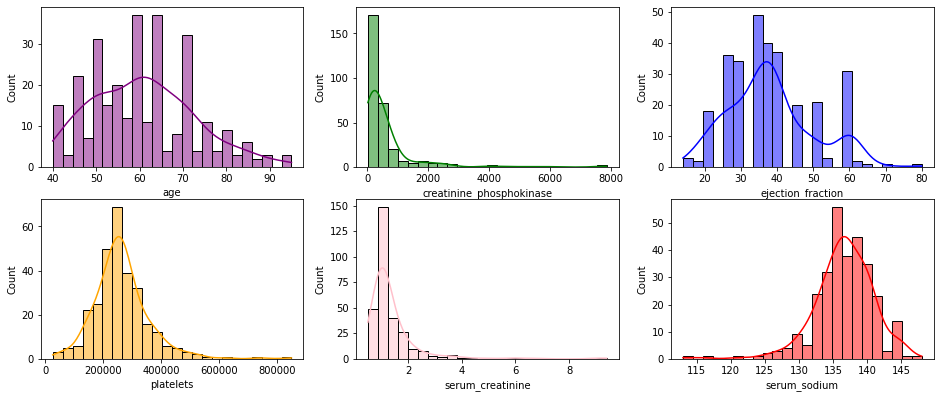

In [18]:
#Producing a distribution plots for the key clinical attributes
plt.figure(figsize = [16, 10])
plt.subplot(3, 3, 1)
sns.histplot(X['age'], kde=True, 
             bins=int(120/5), color = 'purple')

plt.subplot(3, 3, 2)
sns.histplot(X['creatinine_phosphokinase'], kde=True, 
             bins=int(120/5), color = 'green')

plt.subplot(3, 3, 3)
sns.histplot(X['ejection_fraction'], kde=True, 
             bins=int(120/5), color = 'blue')

plt.subplot(3, 3, 4)
sns.histplot(X['platelets'], kde=True, 
             bins=int(120/5), color = 'orange')

plt.subplot(3, 3, 5)
sns.histplot(X['serum_creatinine'], kde=True, 
             bins=int(120/5), color = 'pink')
plt.subplot(3, 3, 6)
sns.histplot(X['serum_sodium'], kde=True, 
             bins=int(120/5), color = 'red')

plt.show()

From the above distribution of some key clinical attributes in the dataset we can say the attributes like age, ejection fraction, platelets, serum sodium have a fairly normal distribution while creatinine phosphokinase and serum creatinine have distributions that is skewed towards lower values. Since follow-up time (measured in days) is not a clinical attribute I am disrigarding it for building machine learning model

For further data exploration I have loaded the data into SQlite database to use SQL queries that can retrive some interesting attributes of the dataset

In [19]:
conn = sql.connect('Clinical.db')
clinical_data.to_sql('Clinical_data', conn, if_exists = 'replace')
pd.read_sql('SELECT * FROM Clinical_data LIMIT 3', conn)

,index,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1


In [20]:
# Checking Patients suffering from decrease of red blood cells or hemoglobin
anaemia_count = pd.read_sql('SELECT anaemia,COUNT(*) AS count FROM Clinical_data GROUP BY anaemia', conn)
anaemia_count.head()

,anaemia,count
0,0,170
1,1,129


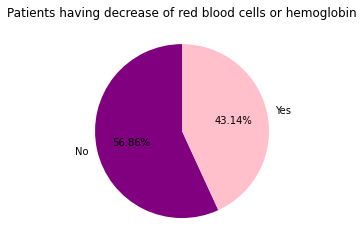

In [21]:
plt.pie(anaemia_count['count'],labels=['No','Yes'],colors=['purple','pink'] , startangle=90, autopct='%1.2f%%')

plt.title('Patients having decrease of red blood cells or hemoglobin')
plt.show()

From the pie chart we can see that greater percentage of the patients (56.86%) in the dataset do not suffer from anaemia

In [22]:
# Checking Patients having decrease of red blood cells or hemoglobin
diabetes_count = pd.read_sql('SELECT diabetes,COUNT(*) AS count FROM Clinical_data GROUP BY diabetes', conn)

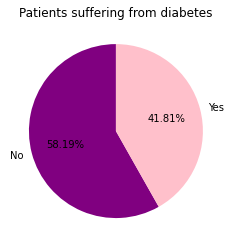

In [23]:
plt.pie(diabetes_count['count'],labels=['No','Yes'],colors=['purple','pink'] , startangle=90, autopct='%1.2f%%')

plt.title('Patients suffering from diabetes')
plt.show()

In [24]:
# Checking Patients suffering from hypertension
high_blood_pressure_count = pd.read_sql('SELECT high_blood_pressure,COUNT(*) AS count FROM Clinical_data GROUP BY high_blood_pressure', conn)


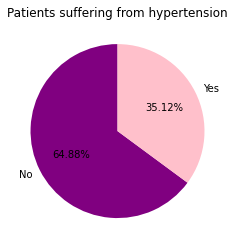

In [25]:
plt.pie(high_blood_pressure_count['count'],labels=['No','Yes'],colors=['purple','pink'] , startangle=90, autopct='%1.2f%%')

plt.title('Patients suffering from hypertension')
plt.show()

In [26]:
# Checking Patients suffering from hypertension
sex_count = pd.read_sql('SELECT sex,COUNT(*) AS count FROM Clinical_data GROUP BY sex', conn)

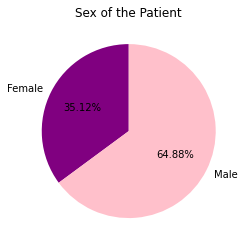

In [27]:
plt.pie(sex_count['count'],labels=['Female','Male'],colors=['purple','pink'] , startangle=90, autopct='%1.2f%%')

plt.title('Sex of the Patient')
plt.show()

In [28]:
# Checking Patients suffering from hypertension
smoke_count = pd.read_sql('SELECT smoking,COUNT(*) AS count FROM Clinical_data GROUP BY smoking', conn)

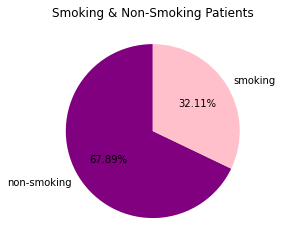

In [29]:
plt.pie(smoke_count['count'],labels=['non-smoking','smoking'],colors=['purple','pink'] , startangle=90, autopct='%1.2f%%')

plt.title('Smoking & Non-Smoking Patients')
plt.show()

Seeing the above pie charts we can say that there would be comparatively there are more number of patients surviving in the given dataset.

Since we are only considering the clinical features for model building I have removed the folloewup time variables for the initial predictive models

In [30]:
X_new = X.drop(['time'], axis=1)
X_new.shape

(299, 11)

## Building Machine Learning Models

In [31]:
#Splitting the data into train & test set

X_train, X_test, y_train, y_test = train_test_split(X_new, y.values.ravel(), test_size=0.3, random_state=1)

### Logistic Regression

In [32]:
log_classifier = LogisticRegression()
log_classifier.fit(X_train,y_train)
ytrain_predLR = log_classifier.predict_proba(X_train)
ytrain_predLR_actual = log_classifier.predict(X_train)
print('Logistic train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_predLR[:,1])))
print('Logistic train Accuracy: {} '.format(accuracy_score(y_train, ytrain_predLR_actual)))
ytest_predLR = log_classifier.predict_proba(X_test)
ytest_predLR_actual = log_classifier.predict(X_test)
print('Logistic test roc-auc: {}'.format(roc_auc_score(y_test, ytest_predLR[:,1])))
print('Logistic test Accuracy: {} '.format(accuracy_score(y_test, ytest_predLR_actual)))

Logistic train roc-auc: 0.740698869475848
Logistic train Accuracy: 0.7416267942583732 
Logistic test roc-auc: 0.7445913461538461
Logistic test Accuracy: 0.7555555555555555 


### Random Forest Classification

In [33]:
rf_model = RandomForestClassifier(max_depth = 2,random_state=1)
rf_model.fit(X_train, y_train)
ytrain_predrf = rf_model.predict_proba(X_train)
ytrain_predrf_actual = rf_model.predict(X_train)
print('Random Forest train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_predrf[:,1])))
print('Random Forest train Accuracy: {} '.format(accuracy_score(y_train, ytrain_predrf_actual)))
ytest_predrf = rf_model.predict_proba(X_test)
ytest_predrf_actual = rf_model.predict(X_test)
print('Random Forest test roc-auc: {}'.format(roc_auc_score(y_test, ytest_predrf[:,1])))
print('Random Forest test Accuracy: {} '.format(accuracy_score(y_test, ytest_predrf_actual)))

Random Forest train roc-auc: 0.8626927029804727
Random Forest train Accuracy: 0.7894736842105263 
Random Forest test roc-auc: 0.7908653846153846
Random Forest test Accuracy: 0.7555555555555555 


### Adaboost Classifier

In [34]:
ada_classifier=AdaBoostClassifier(random_state=1)
ada_classifier.fit(X_train, y_train)
ytrain_predada = ada_classifier.predict_proba(X_train)
ytrain_predada_actual = ada_classifier.predict(X_train)
print('Adaboost train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_predada[:,1])))
print('Adaboost train Accuracy: {} '.format(accuracy_score(y_train, ytrain_predada_actual)))
ytest_predada = ada_classifier.predict_proba(X_test)
ytest_predada_actual = ada_classifier.predict(X_test)
print('Adaboost test roc-auc: {}'.format(roc_auc_score(y_test, ytest_predada[:,1])))
print('Adaboost test Accuracy: {} '.format(accuracy_score(y_test, ytest_predada_actual)))

Adaboost train roc-auc: 0.9618705035971222
Adaboost train Accuracy: 0.9090909090909091 
Adaboost test roc-auc: 0.7052283653846154
Adaboost test Accuracy: 0.7222222222222222 


### XGBoosting Classifier

In [35]:
xgb_classifier = xgb.XGBClassifier(max_depth = 2,verbosity=0, use_label_encoder=False,random_state=1)
xgb_classifier.fit(X_train, y_train)
ytrain_predxgb = xgb_classifier.predict_proba(X_train)
ytrain_predxgb_actual = xgb_classifier.predict(X_train)
print('XGBoost train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_predxgb[:,1])))
print('XGBoost test Accuracy: {} '.format(accuracy_score(y_train, ytrain_predxgb_actual)))
ytest_predxgb = xgb_classifier.predict_proba(X_test)
ytest_predxgb_actual = xgb_classifier.predict(X_test)
print('XGBoost test roc-auc: {}'.format(roc_auc_score(y_test, ytest_predxgb[:,1])))
print('XGBoost test Accuracy: {} '.format(accuracy_score(y_test, ytest_predxgb_actual)))

XGBoost train roc-auc: 0.992497430626927
XGBoost test Accuracy: 0.9569377990430622 
XGBoost test roc-auc: 0.7289663461538461
XGBoost test Accuracy: 0.7666666666666667 


It would be good to do feature selection and hyperparameter tuning to select best parameters for the above built predictive models

## Feature Selection

Univariate feature selection works by selecting the best features based on univariate statistical tests. Below I am using selectKBest which can return best features based on ANOVA F-value between target/feature.

In [53]:
# Perform feature selection using SelectKBest class and f classif() function (Univariate Analysis)
selector = SelectKBest(score_func=f_classif, k=11)
fit = selector.fit(X_new, y.values.ravel())
scores =fit.scores_
features = fit.transform(X_new)

In [54]:
Top_Features = pd.DataFrame()
Top_Features['Features'] = X_new.columns
Top_Features['Feature Importance Score'] = scores
Top_Features = Top_Features.sort_values(by = 'Feature Importance Score', ascending = False)
Top_Features

,Features,Feature Importance Score
7,serum_creatinine,28.158492
4,ejection_fraction,23.094063
0,age,20.435946
8,serum_sodium,11.765331
5,high_blood_pressure,1.881937
1,anaemia,1.310096
2,creatinine_phosphokinase,1.173259
6,platelets,0.718880
10,smoking,0.047333
9,sex,0.005534


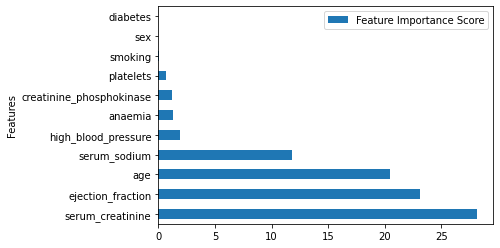

In [55]:
Top_Features.plot.barh(x='Features', y='Feature Importance Score')
plt.show()

From the above plot we can see that serum creatinine and ejection fraction are the top 2 important features, Thus I have used these key features as input variables to obtain accurate predictions.

Since Random Forest, Adaboost and XGBoost are tree based we can find the feature importance based on each of these models

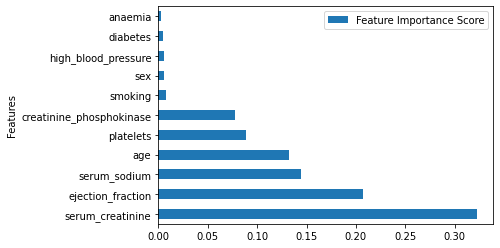

In [39]:
RF_Top_Features = pd.DataFrame()
RF_Top_Features['Features'] = X_new.columns
RF_Top_Features['Feature Importance Score'] = rf_model.feature_importances_
RF_Top_Features = RF_Top_Features.sort_values(by = 'Feature Importance Score', ascending = False)
RF_Top_Features.plot.barh(x='Features', y='Feature Importance Score')
plt.show()

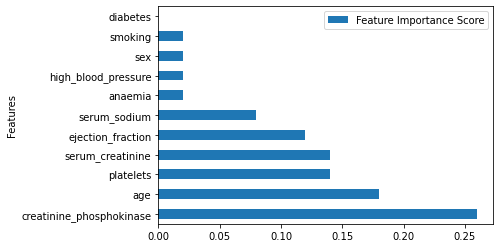

In [40]:
Ada_Top_Features = pd.DataFrame()
Ada_Top_Features['Features'] = X_new.columns
Ada_Top_Features['Feature Importance Score'] = ada_classifier.feature_importances_
Ada_Top_Features = Ada_Top_Features.sort_values(by = 'Feature Importance Score', ascending = False)
Ada_Top_Features.plot.barh(x='Features', y='Feature Importance Score')
plt.show()

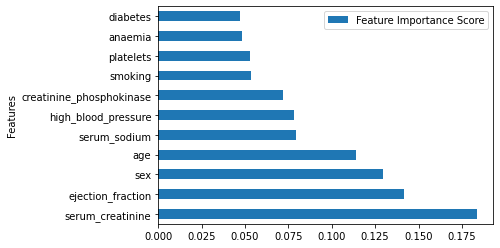

In [41]:
xgb_Top_Features = pd.DataFrame()
xgb_Top_Features['Features'] = X_new.columns
xgb_Top_Features['Feature Importance Score'] = xgb_classifier.feature_importances_
xgb_Top_Features = xgb_Top_Features.sort_values(by = 'Feature Importance Score', ascending = False)
xgb_Top_Features.plot.barh(x='Features', y='Feature Importance Score')
plt.show()

Based on the Univariate analysis and the feature importances from each model, serum creatinine and ejection fraction appear to be important features to accurately predict patients survival. Thus I have selected these features to build an accurately predicting model. Since followup time could be important aspect that I did not include in the earlier models I have tried to include it as one of the input feature for final models

In [42]:
#Splitting the data into train & test set

X_selected = X[['serum_creatinine','ejection_fraction','time']]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y.values.ravel(), test_size=0.35, random_state=1)

In [43]:
log_classifier = LogisticRegression()
log_classifier.fit(X_train,y_train)
ytrain_predLR = log_classifier.predict_proba(X_train)
ytrain_predLR_actual = log_classifier.predict(X_train)
print('Logistic train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_predLR[:,1])))
print('Logistic train Accuracy: {} '.format(accuracy_score(y_train, ytrain_predLR_actual)))
ytest_predLR = log_classifier.predict_proba(X_test)
ytest_predLR_actual = log_classifier.predict(X_test)
print('Logistic test roc-auc: {}'.format(roc_auc_score(y_test, ytest_predLR[:,1])))
print('Logistic test Accuracy: {} '.format(accuracy_score(y_test, ytest_predLR_actual)))

Logistic train roc-auc: 0.8925843224820778
Logistic train Accuracy: 0.845360824742268 
Logistic test roc-auc: 0.8557168784029038
Logistic test Accuracy: 0.8095238095238095 


## Hyperparameter Tuning

Selecting the best parameter for Random Forest Model using RandomizedSearchCV

In [44]:
params_rf = {'bootstrap': [True, False],
             'max_depth': [2,4,5,6,8,15,10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 5, 10],
             'n_estimators': [50, 100,150,200, 400, 600, 800]}
search1 = RandomizedSearchCV(estimator = rf_model, param_distributions=params_rf,random_state=42)
search1.fit(X_train, y_train)
print(search1.best_params_)

{'n_estimators': 800, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 80, 'bootstrap': True}


In [45]:
best_rf_model = RandomForestClassifier(n_estimators= 800,min_samples_split = 10, min_samples_leaf= 2, 
                                       max_depth = 80,bootstrap = True, random_state=1)
best_rf_model.fit(X_train, y_train)
ytrain_predrf = best_rf_model.predict_proba(X_train)
ytrain_predrf_actual = best_rf_model.predict(X_train)
print('Random Forest train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_predrf[:,1])))
print('Random Forest train Accuracy: {} '.format(accuracy_score(y_train, ytrain_predrf_actual)))
ytest_predrf = best_rf_model.predict_proba(X_test)
ytest_predrf_actual = best_rf_model.predict(X_test)
print('Random Forest test roc-auc: {}'.format(roc_auc_score(y_test, ytest_predrf[:,1])))
print('Random Forest test Accuracy: {} '.format(accuracy_score(y_test, ytest_predrf_actual)))

Random Forest train roc-auc: 0.977553178986955
Random Forest train Accuracy: 0.9123711340206185 
Random Forest test roc-auc: 0.9033575317604357
Random Forest test Accuracy: 0.8761904761904762 


Selecting the best parameters for the Adaboost Model will further improve the performance of the model and to do that I have used GridSearchCV

In [46]:
# Tuning Adaboost classifier

params_ada = {
    "n_estimators": [50,100, 150],
    "learning_rate": [1, 0.05,0.30]
}

search2 = GridSearchCV(estimator = ada_classifier, param_grid=params_ada)
search2.fit(X_train, y_train)
print(search2.best_params_)

{'learning_rate': 1, 'n_estimators': 100}


In [47]:
best_ada_classifier=AdaBoostClassifier(learning_rate = 1, n_estimators =  100, random_state=1)
best_ada_classifier.fit(X_train, y_train)
ytrain_predada = best_ada_classifier.predict_proba(X_train)
ytrain_predada_actual = best_ada_classifier.predict(X_train)
print('Adaboost train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_predada[:,1])))
print('Adaboost train Accuracy: {} '.format(accuracy_score(y_train, ytrain_predada_actual)))
ytest_predada = best_ada_classifier.predict_proba(X_test)
ytest_predada_actual = best_ada_classifier.predict(X_test)
print('Adaboost test roc-auc: {}'.format(roc_auc_score(y_test, ytest_predada[:,1])))
print('Adaboost test Accuracy: {} '.format(accuracy_score(y_test, ytest_predada_actual)))

Adaboost train roc-auc: 0.995886708191327
Adaboost train Accuracy: 0.9587628865979382 
Adaboost test roc-auc: 0.8491379310344827
Adaboost test Accuracy: 0.8095238095238095 


Selecting the best parameters for the XGBoost Model will further improve the performance of the model and to do that I have used RandomizedSerchCV which can provide best parameters out of different combinations of availables input parameters

In [48]:
#Tuning XGBoost Model

params = {
"colsample_bytree": [0.3,0.5,0.7],
"learning_rate": [0.05,0.30,1], # default 0.1
"max_depth": [2,4,5,6,8,15], # default 3
"n_estimators": [50, 100,150,200, 400, 600, 800], # default 100
"subsample": [0.6, 0.4,1],
"max_child_weight": [1,3,7]
}
search = RandomizedSearchCV(estimator = xgb_classifier, param_distributions=params,random_state=42)
search.fit(X_train, y_train)
print(search.best_params_)

{'subsample': 0.4, 'n_estimators': 400, 'max_depth': 4, 'max_child_weight': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.5}


In [49]:
final_xgb_model = xgb.XGBClassifier(subsample= 0.4,colsample_bytree = 0.5, n_estimators= 400,
max_child_weight= 3, learning_rate = 0.05,max_depth = 4,verbose=0, use_label_encoder=False,random_state=1)
final_xgb_model.fit(X_train, y_train)
ytrain_predxgb = final_xgb_model.predict_proba(X_train)
ytrain_predxgb_actual = final_xgb_model.predict(X_train)
print('XGBoost train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_predxgb[:,1])))
print('XGBoost test Accuracy: {} '.format(accuracy_score(y_train, ytrain_predxgb_actual)))
ytest_predxgb = final_xgb_model.predict_proba(X_test)
ytest_predxgb_actual = final_xgb_model.predict(X_test)
print('XGBoost test roc-auc: {}'.format(roc_auc_score(y_test, ytest_predxgb[:,1])))
print('XGBoost test Accuracy: {} '.format(accuracy_score(y_test, ytest_predxgb_actual)))

XGBoost train roc-auc: 0.9721471383241274
XGBoost test Accuracy: 0.9020618556701031 
XGBoost test roc-auc: 0.9047186932849365
XGBoost test Accuracy: 0.8952380952380953 


## Conclusion

From the analysis and models build in this project we can deduce that feature selection based on feature importance scores and hyperparameter tuning of models improves performance of  the implemented ML models. It is seen that serum creatinine and ejection fraction are two key features that help to accurately predict patient's survival with heart failure during follow up period. Thus, these two features can be majorly studies when examining patient’s survival.

In future works I plan to explore other Deep learning based algorithms to further improve the accuracy of the model. Also, I would like to further investigation on other model parameters and features (like follow-up time). It would be interesting to check on other demographic features of the dataset to check if they influence patient's survival probability.

## References

1. https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records
2. Davide Chicco, Giuseppe Jurman: "Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone". BMC Medical Informatics and Decision Making 20, 16 (2020). <a href="https://doi.org/10.1186/s12911-020-1023-5"> [Web Link] </a>